In [168]:
import sys,os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary

# insert project folder to PATH
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from src.models.lstm_model import LSTMModel
from src.config_params import config

Загружаем данные

In [118]:
data = pd.read_csv("../data/raw/RTS Splice_M5.csv", sep='\t')
print(len(data))
data = data[0:10000]
print(len(data))
data.head()


100025
10000


<DATE>    <TIME>  <OPEN>  <HIGH>   <LOW>  <CLOSE>  <TICKVOL>  <VOL>  \
0  2021.01.04  10:00:00  139240  141500  139240   141480       8973  19594   
1  2021.01.04  10:05:00  141480  141770  141320   141640       4970   9196   
2  2021.01.04  10:10:00  141640  141930  141640   141790       3670   7440   
3  2021.01.04  10:15:00  141790  142020  141790   141990       2594   5396   
4  2021.01.04  10:20:00  142000  142150  141920   141990       2797   6434   

   <SPREAD>  
0        10  
1        10  
2        10  
3        10  
4        10

In [119]:
data.rename(columns = {'<DATE>':'DATE','<TIME>':'TIME','<OPEN>':'OPEN','<HIGH>':'HIGH','<LOW>':'LOW','<CLOSE>':'CLOSE','<TICKVOL>':'TICKVOL','<VOL>':'VOL','<SPREAD>':'SPREAD'}, inplace = True )
data.head()

DATE      TIME    OPEN    HIGH     LOW   CLOSE  TICKVOL    VOL  \
0  2021.01.04  10:00:00  139240  141500  139240  141480     8973  19594   
1  2021.01.04  10:05:00  141480  141770  141320  141640     4970   9196   
2  2021.01.04  10:10:00  141640  141930  141640  141790     3670   7440   
3  2021.01.04  10:15:00  141790  142020  141790  141990     2594   5396   
4  2021.01.04  10:20:00  142000  142150  141920  141990     2797   6434   

   SPREAD  
0      10  
1      10  
2      10  
3      10  
4      10

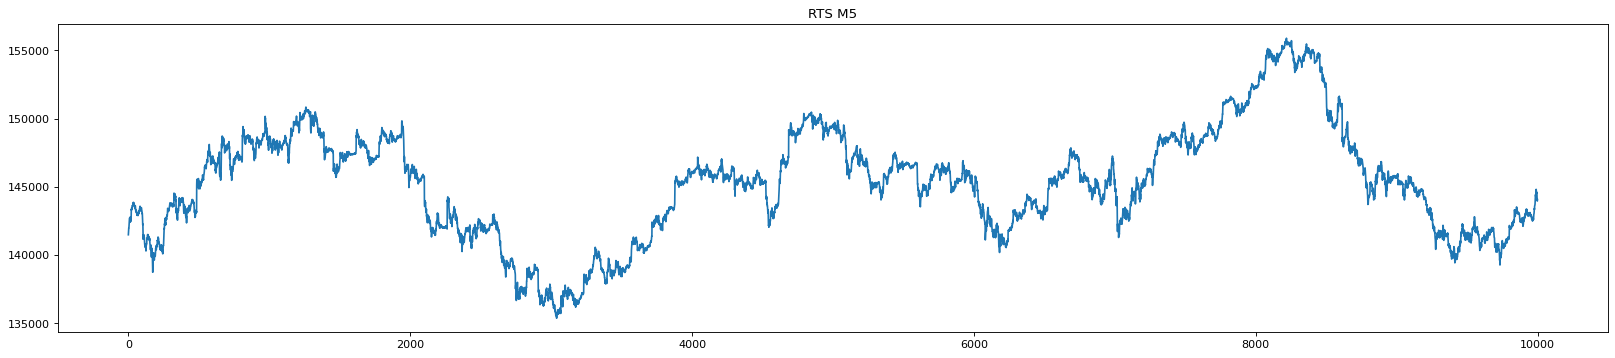

In [120]:
#plot data
fig = plt.figure(figsize=(25, 5), dpi=80)
plt.plot(data["CLOSE"])
plt.title("RTS M5")
plt.show()

In [121]:
scaler = StandardScaler()

data_np = data["CLOSE"].to_numpy()
data_np_2d = data_np.reshape(-1,1)
data_scaled = scaler.fit_transform(data_np_2d)
data_scaled = data_scaled.flatten()
print(data_scaled.shape)
print(data_scaled[0:10])

(10000,)
[-0.94722273 -0.90730342 -0.86987906 -0.81997992 -0.81997992 -0.7800606
 -0.7625959  -0.70521188 -0.64533291 -0.64782787]


In [122]:
def get_x_y(data_in, window_size):
  
    rows_num = data_in.shape[0]
    data_x = []
    data_y = []
    for i in range(rows_num-window_size):
        data_x.append(data_in[i:i+window_size])
        data_y.append(data_in[i+window_size:i+window_size+1])
    return np.array(data_x), np.array(data_y)

In [123]:
train_size = int(len(data)*config["data"]["train_split_part"])
data_x_train, data_y_train = get_x_y(data_scaled[0:train_size], config["data"]["window_size"])
print(data_x_train.shape, data_y_train.shape)
#print(data_scaled[0:window_size+2])
#print(x_train[0:2], y_train[0:2])

(6936, 64) (6936, 1)


In [124]:
test_size = config["data"]["test_split_size"]
data_x_val, data_y_val = get_x_y(data_scaled[train_size:-test_size], config["data"]["window_size"])
print(data_x_val.shape, data_y_val.shape)

(2862, 64) (2862, 1)


In [125]:
data_x_test, data_y_test = get_x_y(data_scaled[-test_size:], config["data"]["window_size"])
print(data_x_test.shape, data_y_test.shape)

(10, 64) (10, 1)


In [126]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (6936, 64, 1) (6936, 1)
Validation data shape (2862, 64, 1) (2862, 1)
Test data shape (10, 64, 1) (10, 1)


In [167]:
model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

In [128]:
#summary(model, (64,1))

In [146]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]
                
        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])
        
        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=config["training"]["scheduler_step_gamma"])

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])


C:\Users\user\PycharmProjects\mlops\venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 64, 1])
torch.Size([32, 

KeyboardInterrupt: 

In [131]:
#save model
torch.save(model.state_dict(), "../models/LSTMModel_weights.pth")

In [134]:
#load model
model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model.load_state_dict(torch.load("../models/LSTMModel_weights.pth"))

<All keys matched successfully>

In [153]:
# predict on the unseen data, tomorrow's price 

model.eval()

x = torch.tensor(data_x_test).float().to(config["training"]["device"])
x = torch.tensor(data_x_test).float().to(config["training"]["device"]).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction.reshape(-1, 1)).flatten()
print(prediction.shape)
print(prediction)

(10,)
[144609.73 144615.88 144610.78 144606.94 144609.47 144607.81 144608.69
 144587.1  144581.61 144581.08]


In [154]:
#plot data target & prediction
prediction_size = len(prediction)
fig = plt.figure(figsize=(25, 5), dpi=80)
plt.plot(data_np[-prediction_size:], label="target price")
plt.plot(prediction, label="prediction price")
plt.title("RTS M5: target / prediction")
plt.show()